# This is a scratch space for building functions
After functions are made, move them to the corresponding folder. 

In [1]:
from openpiv import tools, pyprocess, validation, filters, scaling
from pathlib import Path
import importlib_resources
from video_manipulation.segment_skel import segment_brightfield_ultimate
import cv2
from flow_analysis_comps.PIV.PIV_process import AMF_PIV

import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

from flow_analysis_comps.PIV.definitions import PIV_params, segmentMode

path = importlib_resources.files('openpiv')

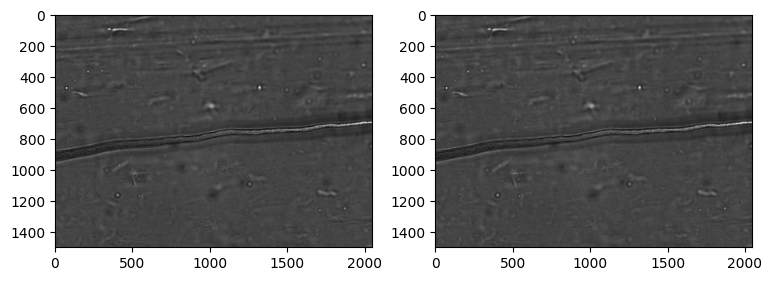

In [2]:
data_adr = Path(r"G:\AMOLF_Data\AMOLF-SHIMIZU Dropbox\Simon van Staalduine")
plate_id = r"20250122_Plate017"
video_id = r"033"
frame_id1 = r"Img/Img_00000.tif"
frame_id2 = r"Img/Img_00001.tif"

mode = "BRIGHTFIELD"
# mode = "FLUO"

frame_a_path = data_adr / video_id / frame_id1
frame_b_path = data_adr / video_id / frame_id2

frame_a = imread(frame_a_path)
frame_b = imread(frame_b_path)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(frame_a, cmap=plt.cm.gray)
axs[1].imshow(frame_b, cmap=plt.cm.gray)
plt.show()

fps = 20/1
t_dt = 1/fps
winsize = 6 # pixels, interrogation window size in frame A
searchsize = 8  # pixels, search area size in frame B
overlap = 1 # pixels, 50% overlap
dt = t_dt # sec, time interval between the two frames

STN_thresh = 1.4

piv_param_obj = PIV_params(
    video_path=data_adr/video_id,
    segment_mode=segmentMode.BRIGHT,
    fps=fps,
    window_size=winsize,
    search_size=searchsize,
    overlap_size=overlap,
    stn_threshold=STN_thresh,
    px_per_mm= 1500/2
)

Found 600 images in target directory.


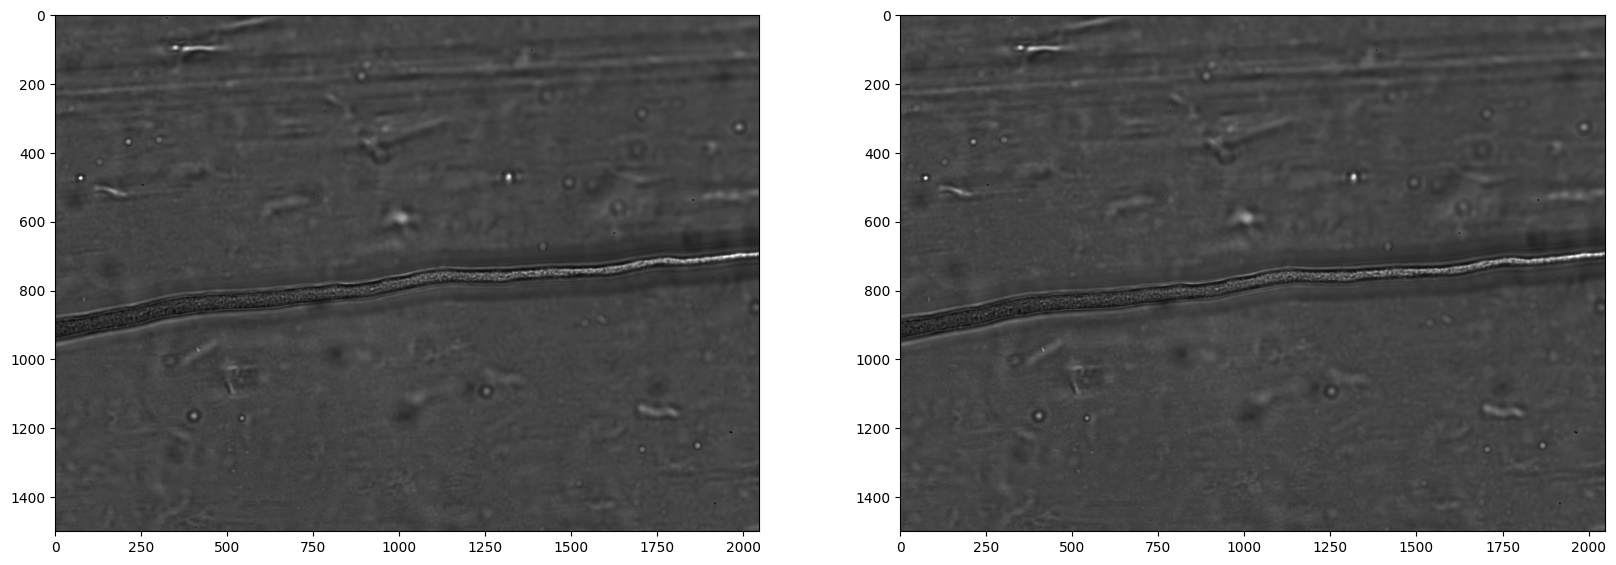

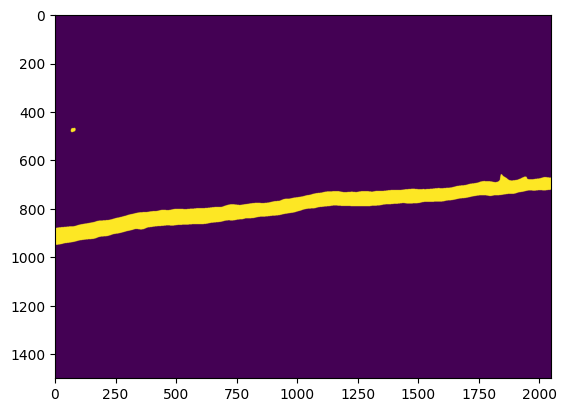

In [3]:
amf_piv_obj = AMF_PIV(piv_param_obj)
amf_piv_obj.plot_raw_images((0,1))
amf_piv_obj.plot_segmentation()

In [ ]:
segmented_im = segment_brightfield_ultimate([frame_a_path, frame_b_path], mode=mode)
print(segmented_im)
fig, ax = plt.subplots()
ax.imshow(segmented_im)

In [4]:
u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32),
    frame_b.astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)
x, y = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=searchsize,
    overlap=overlap,
)

In [5]:

invalid_mask = validation.sig2noise_val(
    sig2noise,
    threshold = STN_thresh,
)
destined_shape = invalid_mask.shape

segmented_im = cv2.resize(segmented_im, destined_shape[::-1])
segmented_im = np.where(segmented_im > 1, True, False)

invalid_mask  = ~(invalid_mask * segmented_im)

u2, v2 = filters.replace_outliers(
    u0, v0,
    invalid_mask,
    method='localmean',
    max_iter=3,
    kernel_size=3,
)
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(
    x, y, u2, v2,
    scaling_factor = 1501/2,  # 96.52 pixels/millimeter
)

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)
tools.save('exp1_001.txt' , x, y, u3, v3, invalid_mask)


In [ ]:
from matplotlib.colors import hsv_to_rgb
hue = np.arctan2(v3, u3) 

val = np.linalg.norm([v3, u3], axis=0)
val /= np.nanmax(val)
val = np.sqrt(val)
sat = np.ones_like(val)

hsv_im = np.array([hue/ (2*np.pi) + 0.5, sat, val])
hsv_im = np.moveaxis(hsv_im, 0, -1)
rgb_im = hsv_to_rgb(hsv_im)

fig, ax = plt.subplot_mosaic([["result", "hue"], ["result","hist"]], figsize=(20,10))
ax["result"].imshow(rgb_im)
ax["hue"].set_title("Hue")
ax["hue"].imshow(np.arctan2(y - 1, x - 1), cmap="hsv")
ax["hist"].hist(hue.flatten(), bins=50)

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
tools.display_vector_field(
    Path('exp1_001.txt'),
    ax=ax, scaling_factor=1501/2,
    scale=4, # scale defines here the arrow length
    width=0.0015, # width is the thickness of the arrow
    on_img=True, # overlay on the image
    image_name= frame_a_path,
);